In [1]:
import logging
import os
from datetime import timedelta
from functools import lru_cache
from typing import Optional

from dotenv import load_dotenv
from pydantic import BaseModel, Field

load_dotenv(dotenv_path="./.env")


def setup_logging():
    """Configure basic logging for the application."""
    logging.basicConfig(
        level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
    )


class LLMSettings(BaseModel):
    """Base settings for Language Model configurations."""

    temperature: float = 0.0
    max_tokens: Optional[int] = None
    max_retries: int = 3


class OpenAISettings(LLMSettings):
    """OpenAI-specific settings extending LLMSettings."""

    api_key: str = Field(default_factory=lambda: os.getenv("OPENAI_API_KEY"))
    default_model: str = Field(default="gpt-4o")
    embedding_model: str = Field(default="text-embedding-3-small")


class DatabaseSettings(BaseModel):
    """Database connection settings."""

    service_url: str = Field(default_factory=lambda: os.getenv("TIMESCALE_SERVICE_URL"))


class VectorStoreSettings(BaseModel):
    """Settings for the VectorStore."""

    table_name: str = "embeddings"
    embedding_dimensions: int = 1536
    time_partition_interval: timedelta = timedelta(days=7)


class Settings(BaseModel):
    """Main settings class combining all sub-settings."""

    openai: OpenAISettings = Field(default_factory=OpenAISettings)
    database: DatabaseSettings = Field(default_factory=DatabaseSettings)
    vector_store: VectorStoreSettings = Field(default_factory=VectorStoreSettings)


@lru_cache()
def get_settings() -> Settings:
    """Create and return a cached instance of the Settings."""
    settings = Settings()
    setup_logging()
    return settings

# Coding the Vectorstore from Scratch

In [ ]:
from openai import OpenAI
from timescale_vector import client

def initialize_clients(settings):
	"""Initializing all necessary clients."""
	
	# Initializing VectorStore
	service_url = settings.database.service_url
	table_name = settings.vector_store.table_name
	embedding_dimensions = settings.vector_store.embedding_dimensions
	time_partition_interval = settings.vector_store.time_partition_interval

	# Creating vectorstore connection using timescale
	vec_client = client.Sync(
		service_url=service_url,
		table_name=table_name,
		num_dimensions=embedding_dimensions,
		time_partition_interval=time_partition_interval
	)

	# Initializing OpenAI Client
	openai_api_key = settings.openai.api_key
	openai_client = OpenAI(api_key=openai_api_key)

	# Initializing Embedding Model
	embeddding_model = settings.openai.embedding_model

	return vec_client, openai_client, embeddding_model

In [3]:
settings = get_settings()
vec_client, openai_client, embeddding_model = initialize_clients(settings)

In [ ]:
def get_embedding(openai_client, text):
	"""Function to create embeddings."""

	# Removing \n with space
	text = text.replace('\n', ' ')
	# Creating Embedding
	embedding = (openai_client.embeddings.create(input=[text], model=embeddding_model).data[0].embedding)

	return embedding

def create_tables(vec_client):
	"""Function to create table."""

	# Creating table using vector client
	vec_client.create_tables()
	
def create_index(vec_client):
	"""Function to create embedding index."""

	# Creating Embedding Index using DiskAnnIndex
	vec_client.create_embedding_index(client.DiskAnnIndex())
	
def drop_index(vec_client):
	"""Function to drop embedding index."""

	# Dropping Embedding Index
	vec_client.drop_embedding_index()

def upsert(vec_client, df):
	"""Function to upload/insert dataframe with embeddings to table."""

	# Converting dadtaframe to records
	records = df.to_records(index=False)

	# Inserting the records to table
	vec_client.upsert(list(records))

In [ ]:
def create_dataframe_from_results(results):
    

In [ ]:
def search(vec_client, query_text, limit, metadata_filter, predicates, time_range, return_dataframe):
	"""Function to search for Embeddings similar to input embedding."""
    
	# Converting input query to embedding
	query_embedding = get_embedding(query_text)

	# Creating Search arguments dictionary
	search_args = {
		'limit': limit
	}

	# Adding metadata filter to search arguments if available
	if metadata_filter:
		search_args['metadata_filter'] = metadata_filter

	# Adding predicates to search arguments if available
	if predicates:
		search_args['predicates'] = predicates

	# Adding time range to search arguments if available
	if time_range:
		start_date, end_date = time_range
		search_args['uuid_time_filter'] = client.UUIDTimeRange(start_date, end_date)

	# Searching for most similar embeddings
	results = vec_client.search(query_embedding, **search_args)

	# Returning dataframe with similar embeddings if set on
	if return_dataframe:
		return create_dataframe_from_results(results)
	else:
		return results

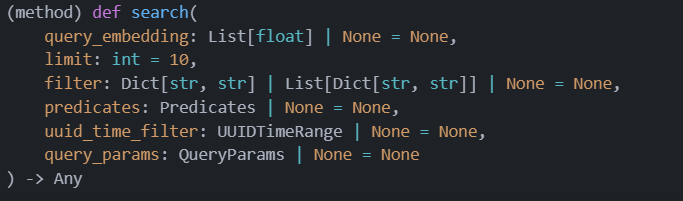

In [18]:
from datetime import datetime

import pandas as pd
# from database.vector_store import VectorStore
from timescale_vector.client import uuid_from_time

# Initialize VectorStore
# vec = VectorStore()

# Read the CSV file
df = pd.read_csv("data/faq_dataset.csv", sep=";")


# Prepare data for insertion
def prepare_record(row):
    """Prepare a record for insertion into the vector store.

    This function creates a record with a UUID version 1 as the ID, which captures
    the current time or a specified time.

    Note:
        - By default, this function uses the current time for the UUID.
        - To use a specific time:
          1. Import the datetime module.
          2. Create a datetime object for your desired time.
          3. Use uuid_from_time(your_datetime) instead of uuid_from_time(datetime.now()).

        Example:
            from datetime import datetime
            specific_time = datetime(2023, 1, 1, 12, 0, 0)
            id = str(uuid_from_time(specific_time))

        This is useful when your content already has an associated datetime.
    """
    content = f"Question: {row['question']}\nAnswer: {row['answer']}"
    embedding = get_embedding(openai_client, content)
    return pd.Series(
        {
            "id": str(uuid_from_time(datetime.now())),
            "metadata": {
                "category": row["category"],
                "created_at": datetime.now().isoformat(),
            },
            "contents": content,
            "embedding": embedding,
        }
    )


records_df = df.apply(prepare_record, axis=1)

2025-04-03 17:17:50,334 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-03 17:17:52,037 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-03 17:17:54,495 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-03 17:17:55,829 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-03 17:17:56,542 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-03 17:17:58,590 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-03 17:17:59,308 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-03 17:18:00,291 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-03 17:18:01,713 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-03 17:18:02,240 - INFO - HTTP

In [21]:
records_df.to_records(index=False)

rec.array([('78b82c1a-1081-11f0-bf01-72164c8d8895', {'category': 'Shipping', 'created_at': '2025-04-03T17:17:51.064681'}, 'Question: What are your shipping options?\nAnswer: We offer standard (3-5 business days) and express (1-2 business days) shipping options.', list([-0.00946081057190895, 0.013697080314159393, 0.037935711443424225, 0.009553279727697372, 0.025799056515097618, 0.01565050333738327, -0.0029561419505625963, -0.016008824110031128, 0.014090076088905334, -0.00042406044667586684, -0.030283840373158455, 0.011870802380144596, -0.03883729130029678, 0.008801963180303574, -0.0430215448141098, 0.004129351582378149, -0.014563984237611294, -0.02459695003926754, -0.0704619437456131, 0.038883525878190994, 0.007715444080531597, 0.006438205484300852, 0.027694687247276306, -0.000913138675969094, -0.0171878132969141, -0.005461493972688913, -0.0008762952638790011, -0.005499059800058603, 0.018297450616955757, -0.0592268668115139, 0.015026332810521126, -0.01274926494807005, 0.0357395559549331

In [ ]:

# Create tables and insert data
vec.create_tables()
vec.create_index()  # DiskAnnIndex
vec.upsert(records_df)

In [9]:
from timescale_vector.client import uuid_from_time
from datetime import datetime

uuid_from_time(datetime.now())

UUID('f5e45266-107e-11f0-bd74-9d0b6a6b5557')

In [10]:
datetime.now().isoformat()

'2025-04-03T17:00:12.445832'